<a href="https://colab.research.google.com/github/bielperello/Node21_AA_2025-26/blob/modelsClas2/Node21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projecte Node21: Classificació i Detecció de Nòduls Pulmonars en Radiografies de Pit.

In [1]:
from google.colab import drive
import os

# 1. Connectar Drive
drive.mount('/content/drive')

# 2. Descomprimir el ZIP (ajusta la ruta si el nom de la carpeta al Drive és diferent)
# El posem a /content/ perquè la lectura des del disc local del Colab és molt més ràpida que des del Drive directe
!unzip "/content/drive/MyDrive/Projecte_Node21/colab_data.zip" -d "/content/dataset_reduit"

# 3. Instal·lar la llibreria per llegir imatges mèdiques
!pip install SimpleITK

# Instal·lar la llibreria OpenCV
!pip install opencv-python

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Projecte_Node21/colab_data.zip
  inflating: /content/dataset_reduit/metadata.csv  
  inflating: /content/dataset_reduit/images/c0008.mha  
  inflating: /content/dataset_reduit/images/c0012.mha  
  inflating: /content/dataset_reduit/images/c0013.mha  
  inflating: /content/dataset_reduit/images/c0021.mha  
  inflating: /content/dataset_reduit/images/c0022.mha  
  inflating: /content/dataset_reduit/images/c0025.mha  
  inflating: /content/dataset_reduit/images/c0026.mha  
  inflating: /content/dataset_reduit/images/c0028.mha  
  inflating: /content/dataset_reduit/images/c0035.mha  
  inflating: /content/dataset_reduit/images/c0037.mha  
  inflating: /content/dataset_reduit/images/c0040.mha  
  inflating: /content/dataset_reduit/images/c0042.mha  
  inflating: /content/dataset_reduit/images/c0043.mha  
  inflating: /content/dataset_reduit/images/c0044.mha  
  inflating: /content/dataset_reduit/images/c0046.mha  
  inflating: /cont

## Introducció
En aquest projecte abordarem la detecció de nòduls pulmonars en radiografies de tòrax (CXR) seguint l'enunciat del repte **Node21** ([enllaç al repte](https://node21.grand-challenge.org/)). El repte Node21 proporciona un conjunt de dades públic de radiografies frontals de pit amb nòduls pulmonars anotats mitjançant **caixes delimitadores** (bounding boxes). En total consta d'aproximadament **4.882 radiografies**, de les quals **1.134** contenen almenys un nòdul i **3.748** imatges no en contenen, actuant com a casos negatius.  

L'objectiu consisteix en aplicar tècniques d'aprenentatge automàtic al problema proposat. S'han definit un **conjunt de tasques seqüencials** per tal de facilitar-ne el desenvolupament:

1. **Classificació**: Desenvolupar un sistema de classificació binària capaç de determinar si una radiografia conté nòduls pulmonars. Aquesta tasca es resoldrà mitjançant l'avaluació de **quatre models diferents**, alguns d'entrenats des de zero i d'altres aprofitant tècniques de *transfer learning*.
2. **Detecció**: Implementar models de detecció per localitzar els nòduls en la imatge, identificant-ne la posició amb caixes delimitadores. Per aquesta tasca es faran servir **dues arquitectures diferents** basades en *deep learning*.
3. **Innovació**: S’obre la possibilitat d’aplicar tècniques avançades o enfocaments propis que ampliïn o millorin les metodologies aplicades.

Per abordar aquestes tasques, utilitzarem un únic *notebook* Jupyter que integrarà tot el codi i explicacions necessàries. S'empraran diverses tècniques i models d'**aprenentatge automàtic** i **aprenentatge profund** vists a classe.


## Preparació de l'entorn i dependències
Abans de començar, assegurem-nos de tenir instal·lades totes les **dependències** necessàries. El projecte requerirà les biblioteqües següents:

- **NumPy** - per a manipulació de dades numèriques i de taules (anotacions).
- **PyTorch** - per construir i entrenar els models de CNN i Transfer Learning.
- **Matplotlib** - per a la visualizació de gràfiques i imatges.

Podem instal·lar els paquets que falten directament des del notebool. Per exemple:

`pip install torch torchvision scikit-learn matplotlib numpy`

També assegurarem una estructura de carpetes correcta en el directori de treball actual:

- `data/` - Contindrà les dades del NODE21 (imatges i anotacions).
- `utils/` - Codi de suport reutilitzable, com ara funcions d’augmentació, classes Dataset, funcions per dibuixar caixes, etc.
- `outputs/` - Elements de sortida.
-

## Obtenció i preparació de les dades Node21

Per dur a terme les tasques de classificació i detecció de nòduls pulmonars, utilitzarem les dades proporcionades pel repte NODE21, descarregades des del repositori oficial de Zenodo. Aquest conjunt inclou radiografies de tòrax simulades amb nòduls inserits artificialment i anotacions detallades sobre la seva posició.

A causa de la mida del conjunt complet (~35 GB), no resulta eficient entrenar directament amb totes les imatges en un entorn personal. Per això, optarem per treballar amb un subconjunt configurable del total d’imatges, mantinguent una distribució equilibrada entre imatges positives (amb nòduls) i negatives (sense nòduls), que és fonamental per garantir una bona generalització del model.

Les imatges es troben dins la carpeta:

`data/cxr_images/proccessed_data/images/`

i tenen format **.mha**. Les anotacions associades es troben al fitxer

`data/cxr_images/proccessed_data/metadata.csv`

Aquest fitxer indica, per a cada imatge, el seu nom, l'etiqueta (label per diferenciar si hi ha nòdul o no) i les coordenades **(x, y, width, height)** corresponents, en cas de no haver nòdul (label 0) el valors són de 0. Aquest enfocament ens permet construir tant:

- **Etiquetes binàries** per a classificació: 1 si hi ha algun nòdul, 0 si no.
- **Bounding boxes per detecció**: una o més caixes per imatge, o cap.

In [ ]:
'''
# 1. Connectar amb Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Instal·lar SimpleITK (necessari per a fitxers .mha)
!pip install SimpleITK

# 3. Descomprimir les dades a la memòria local del Colab (molt més ràpid)
# CANVIA LA RUTA per la del teu fitxer .zip al Drive
!unzip "/content/drive/MyDrive/NODE21/colab_data.zip" -d "/content/"

# 4. Actualitzar rutes per al Colab
import os
import sys

BASE_PATH = "/content/drive/MyDrive/NODE21" # Ajusta segons la teva carpeta de Drive
sys.path.append(BASE_PATH) # Perquè Colab trobi els teus fitxers .py

IMG_DIR = "/content/colab_data/images"
ANNOTATION_FILE = "/content/colab_data/metadata.csv"
'''

In [2]:
import os
import sys
import torch
import pandas as pd
import SimpleITK as sitk
import numpy as np
import cv2
import matplotlib.pyplot as plt
#import Node21_Utils as Utils
#import Node21_Models as Models

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

'''
# Ruta a les imatges i anotacions
IMG_DIR = "data/cxr_images/proccessed_data/images"
ANNOTATION_FILE = "./data/cxr_images/proccessed_data/metadata.csv"

# Nombre total d'imatges a utilitzar (ajustable)
N_IMAGES = 2000  # Exemple: 500 imatges en total (positives + negatives)
VAL_RATIO = 0.25  # 25% per a validació

# Mida d'entrada desitjada per al model
IMG_SIZE = 512
# Mida del batch
BATCH_SIZE = 32
'''
# Per dur a terme proves al colab, canviem la ruta on hem afegit el zip amb el dataset reduït i realitzem un parell de canvis
IMG_DIR = "/content/dataset_reduit/images"
ANNOTATION_FILE = "/content/dataset_reduit/metadata.csv"

sys.path.append("/content/drive/MyDrive/Projecte_Node21")

N_IMAGES = len(os.listdir(IMG_DIR))
VAL_RATIO = 0.25
IMG_SIZE = 512
BATCH_SIZE = 32

In [3]:
import pandas as pd
import os

# --- VERSIÓ ORIGINAL COMENTADA ---
# df = pd.read_csv(ANNOTATION_FILE)
# annotations_dict = {}
# labels_dict = {}
# for _, row in df.iterrows():
#     img_id = str(row['img_name']).replace('.mha', '')
#     label = int(row["label"])
#     if img_id in labels_dict:
#         labels_dict[img_id] = max(labels_dict[img_id], label)
#     else:
#         labels_dict[img_id] = label
#     if label == 1 and float(row["width"]) > 0 and float(row["height"]) > 0:
#         box = [float(row["x"]), float(row["y"]), float(row["width"]), float(row["height"])]
#         annotations_dict.setdefault(img_id, []).append(box)
# for img_id in labels_dict.keys():
#     annotations_dict.setdefault(img_id, [])
# n_pos = sum(labels_dict[i] for i in labels_dict)
# n_neg = len(labels_dict) - n_pos
# print(f"Total imatges: {len(labels_dict)} | Positives: {n_pos} | Negatives: {n_neg}")

# --- VERSIÓ ESPECÍFICA PER AL COLAB ---

# Carreguem el CSV només per creuar les dades amb els fitxers reals
df_full = pd.read_csv(ANNOTATION_FILE)

# Obtenim la llista de fitxers reals que hi ha al disc del Colab
files_reals = {f.replace('.mha', '') for f in os.listdir(IMG_DIR) if f.endswith('.mha')}

# Filtrem el DataFrame original per quedar-nos només amb les files de les imatges que tenim
df = df_full[df_full['img_name'].str.replace('.mha', '').isin(files_reals)].copy()

annotations_dict = {}
labels_dict = {}

for _, row in df.iterrows():
    img_id = str(row['img_name']).replace('.mha', '')
    label = int(row["label"])

    # Guardem la label (1 si hi ha nòdul, 0 si no)
    if img_id in labels_dict:
        labels_dict[img_id] = max(labels_dict[img_id], label)
    else:
        labels_dict[img_id] = label

    # Guardem les caixes de detecció només si la imatge existeix i té nòdul
    if label == 1 and float(row["width"]) > 0 and float(row["height"]) > 0:
        box = [float(row["x"]), float(row["y"]), float(row["width"]), float(row["height"])]
        annotations_dict.setdefault(img_id, []).append(box)

# Assegurem que totes les imatges del Colab tinguin entrada (encara que estiguin buides)
for img_id in files_reals:
    labels_dict.setdefault(img_id, 0) # Si no estava al CSV per error, assumim sana
    annotations_dict.setdefault(img_id, [])

# Estadístiques reals del que tens al núvol
n_pos = sum(labels_dict.values())
n_neg = len(labels_dict) - n_pos
print(f"✅ Dades Colab: {len(labels_dict)} imatges reals trobades.")
print(f"📊 Distribució: {n_pos} Positives | {n_neg} Negatives")

✅ Dades Colab: 2000 imatges reals trobades.
📊 Distribució: 465 Positives | 1535 Negatives


In [4]:
# --- CODI ORIGINAL COMENTAT ---
# img_ids = list(labels_dict.keys())
# img_labels = [labels_dict[i] for i in img_ids]
# if N_IMAGES > len(img_ids):
#     N_IMAGES = len(img_ids)
# _, subsampled_ids, _, _ = train_test_split(
#     img_ids, img_labels, test_size=N_IMAGES, stratify=img_labels, random_state=42)
# labels_subsampled = [labels_dict[i] for i in subsampled_ids]
# X_train, X_val = train_test_split(subsampled_ids, test_size=VAL_RATIO, stratify=labels_subsampled, random_state=42)

# --- VERSIÓ PER AL COLAB ---
# Com que ja tenim les imatges filtrades al labels_dict de la cel·la anterior:
img_ids_colab = list(labels_dict.keys())
img_labels_colab = [labels_dict[i] for i in img_ids_colab]

# Dividim directament les imatges que tenim al Colab en Train i Val
# Utilitzem el VAL_RATIO (0.25) que ja tenies definit
X_train, X_val = train_test_split(
    img_ids_colab,
    test_size=VAL_RATIO,
    stratify=img_labels_colab,
    random_state=42
)

print(f"✅ Partició completada!")
print(f"Samples totals al Colab: {len(img_ids_colab)}")
print(f"Samples d'entrenament: {len(X_train)}")
print(f"Samples de validació: {len(X_val)}")

✅ Partició completada!
Samples totals al Colab: 2000
Samples d'entrenament: 1500
Samples de validació: 500


In [ ]:
'''
import os
import shutil
import zipfile
from tqdm import tqdm

# 1. Definir rutes (ajusta-les si les teves són diferents)
# On són les 37GB d'imatges
ORIGIN_IMG_DIR = "data/cxr_images/proccessed_data/images"
# On està el fitxer metadata.csv
ORIGIN_METADATA = "./data/cxr_images/proccessed_data/metadata.csv"

# Carpeta temporal on copiarem el subconjunt
temp_dir = "data/colab_subset"
os.makedirs(temp_dir, exist_ok=True)
os.makedirs(os.path.join(temp_dir, "images"), exist_ok=True)

print(f"Copiant {len(subsampled_ids)} imatges al directori temporal...")

# 2. Copiar només les imatges seleccionades per l'estratificació
for img_id in tqdm(subsampled_ids):
    src = os.path.join(ORIGIN_IMG_DIR, f"{img_id}.mha")
    dst = os.path.join(temp_dir, "images", f"{img_id}.mha")
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f"Alerta: No s'ha trobat la imatge {img_id}.mha")

# 3. Copiar el metadata.csv (és vital per al DataLoader)
shutil.copy(ORIGIN_METADATA, os.path.join(temp_dir, "metadata.csv"))

# 4. Crear el fitxer ZIP
zip_name = "colab_data.zip"
print(f"Creant el fitxer {zip_name}...")

with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(temp_dir):
        for file in files:
            # Creem la ruta relativa per dins del ZIP
            rel_path = os.path.relpath(os.path.join(root, file), temp_dir)
            zipf.write(os.path.join(root, file), rel_path)

print(f"✅ Fet! Puja el fitxer '{zip_name}' al teu Google Drive.")
'''

In [5]:
# --- RUTA ORIGINAL COMENTADA ---
# img_p = sitk.ReadImage("data/cxr_images/proccessed_data/images/c0875.mha")

# --- RUTA ADAPTADA AL COLAB ---
# Utilitzem la variable IMG_DIR que hem definit abans per coherència
ruta_prova = os.path.join(IMG_DIR, "c0875.mha")

if os.path.exists(ruta_prova):
    img_p = sitk.ReadImage(ruta_prova)
    arr_p = sitk.GetArrayFromImage(img_p)

    print(f"✅ Imatge de prova trobada a: {ruta_prova}")
    print(f"Forma:  {arr_p.shape}")
    print(f"Mínim: {arr_p.min()}")
    print(f"Màxim: {arr_p.max()}")
else:
    # Si la imatge c0875 no és al teu subconjunt, n'agafem la primera que trobi
    llista_actual = os.listdir(IMG_DIR)
    if llista_actual:
        ruta_alternativa = os.path.join(IMG_DIR, llista_actual[0])
        img_p = sitk.ReadImage(ruta_alternativa)
        arr_p = sitk.GetArrayFromImage(img_p)
        print(f"⚠️ La imatge c0875 no era al ZIP. Provant amb la primera disponible: {llista_actual[0]}")
        print(f"Forma:  {arr_p.shape}")
    else:
        print("❌ Error: No s'ha trobat cap imatge a la carpeta.")
arr_p = sitk.GetArrayFromImage(img_p)

'''
print(f"Forma:  {arr_p.shape}")
print(f"Mínim: {arr_p.min()}")
print(f"Màxim: {arr_p.max()}")
'''

✅ Imatge de prova trobada a: /content/dataset_reduit/images/c0875.mha
Forma:  (1024, 1024)
Mínim: 0
Màxim: 4095


'\nprint(f"Forma:  {arr_p.shape}")\nprint(f"Mínim: {arr_p.min()}")\nprint(f"Màxim: {arr_p.max()}")\n'

La imatge és **2D** (1024, 1024). El rang és fix i conegut **[0,4095]** (representació de 12 bits)

In [6]:
class CXRClassificationDataSet(Dataset):
    def __init__(self, img_ids, labels_dict, img_dir, img_size, transform=None):
        self.img_ids = img_ids
        self.labels_dict = labels_dict
        self.img_dir = img_dir
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        label = self.labels_dict[img_id]

        # Ruta de la imatge .mha
        path = os.path.join(self.img_dir, f"{img_id}.mha")
        img = sitk.ReadImage(path)
        arr = sitk.GetArrayFromImage(img)

        # Normalització per percentils (millora el contrast)
        p1, p99 = np.percentile(arr, (1, 99))
        arr = np.clip(arr, p1, p99)
        arr = ((arr - p1) / (p99 - p1)) * 255.0
        arr = arr.astype(np.uint8)

        # Redimensionar a img_size x img_size
        arr_resized = cv2.resize(arr, (self.img_size, self.img_size))

        # Convertir a tensor (1 canal, H, W) i normalitzar a [0,1]
        tensor = torch.from_numpy(arr_resized).float().unsqueeze(0) / 255

        if self.transform:
            tensor = self.transform(tensor)

        return tensor, torch.tensor(label, dtype=torch.float32)

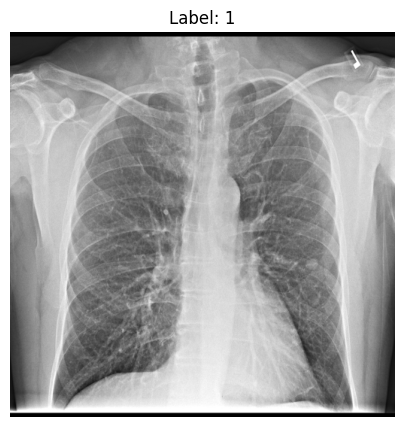

Tipus img: <class 'torch.Tensor'>
Shape img: torch.Size([1, 512, 512])
Min / Max img: 0.0 1.0
Label: 1.0


In [7]:
train_dataset = CXRClassificationDataSet(
    img_ids=X_train,
    labels_dict=labels_dict,
    img_dir=IMG_DIR,
    img_size=512
)

# 170 label 1 / 194 label 0
img, label = train_dataset[170]

plt.figure(figsize=(5, 5))
plt.imshow(img.squeeze(0), cmap="gray")
plt.title(f"Label: {int(label.item())}")
plt.axis("off")
plt.show()

print("Tipus img:", type(img))
print("Shape img:", img.shape)
print("Min / Max img:", img.min().item(), img.max().item())
print("Label:", label.item())

val_dataset = CXRClassificationDataSet(
    img_ids=X_val,
    labels_dict=labels_dict,
    img_dir=IMG_DIR,
    img_size=512
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


## Entrenament del Model 1: TinyCXRNet

In [12]:
import Node21_Models as Models
import Node21_Utils as Utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = Models.TinyCXRNet().to(device)

pos_weight = Utils.compute_pos_weight(X_train, labels_dict, device=device)
loss_fn = Utils.make_loss(pos_weight)
optimizer = Utils.make_optimizer(model, lr=1e-4, weight_decay=1e-3)

history = Utils.fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    device=device,
)

Utils.plot_training_history(history=history)

cuda


Èpoques:   0%|          | 0/10 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 74.12 MiB is free. Process 3676 has 14.67 GiB memory in use. Of the allocated memory 14.41 GiB is allocated by PyTorch, and 124.00 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Entrenament del Model 2: ResNet18Binary

## Entrenament del Model 3: DenseNet121Binary

In [13]:
import Node21_Models as Models
import Node21_Utils as Utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model3 = Models.DenseNet121Binary().to(device)

pos_weight = Utils.compute_pos_weight(X_train, labels_dict, device=device)
loss_fn = Utils.make_loss(pos_weight)
optimizer3 = Utils.make_optimizer(model3, lr=1e-4, weight_decay=1e-4)

# Entrenament
print("Entrenant Model 3: DenseNet121...")
history3 = Utils.fit(
    model=model3,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer3,
    epochs=10,
    device=device,
)

Utils.plot_training_history(history=history3)

cuda
Entrenant Model 3: DenseNet121...


Èpoques:   0%|          | 0/10 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 50.12 MiB is free. Process 3676 has 14.69 GiB memory in use. Of the allocated memory 14.46 GiB is allocated by PyTorch, and 96.58 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Entrenament del Model 4: InceptionV3Binary

In [ ]:
# Configuració del Model 4: InceptionV3
model4 = Models.InceptionV3Binary().to(device)
optimizer4 = Utils.make_optimizer(model4, lr=1e-4, weight_decay=1e-4)

# Entrenament
history4 = Utils.fit(
    model=model4,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer4,
    epochs=10,
    device=device
)

Utils.plot_training_history(history4)

## Classificació

### Model 1

#### Capes de `TinyCXRNet` per a classificació binària (CXR 0/1)

- **Entrada**: radiografies de tòrax en escala de grisos, normalitzades a **[0, 1]**, amb forma **[B, 1, 512, 512]**.
- **Sortida**: classificació binària **0/1** (absència o presència de nòdul).
- **Idea general**: xarxa convolucional lleugera que extreu patrons visuals rellevants de la imatge i retorna un únic **logit** que es transforma en probabilitat mitjançant una funció sigmoide.

Les **capes convolucionals 3×3** (`nn.Conv2d`) són les encarregades d’extreure patrons locals de la imatge, com vores, textures i petites variacions d’intensitat, que són especialment rellevants en radiografies pulmonars.

- L’ús de kernels **3×3** permet capturar context local amb pocs paràmetres, i el `padding=1` manté la mida espacial de la imatge després de la convolució, evitant pèrdua d’informació als marges.

A mesura que la **resolució espacial** es redueix, augmenta el nombre de canals (16 → 32 → 64 → 128) per mantenir la capacitat representacional del model.

- Els primers canals capturen patrons simples.
- Els canals més profunds combinen aquests patrons per descriure estructures més complexes i regions potencialment anòmales.


La **Batch Normalization** (`nn.BatchNorm2d`) s’utilitza per estabilitzar l’entrenament i reduir la variabilitat interna de les activacions. En imatges mèdiques, on poden existir diferències d’adquisició i contrast, aquesta capa ajuda a fer el model més robust i accelera la convergència durant l’entrenament.


El **MaxPool (`nn.MaxPool2d(2)`)** redueix la resolució espacial i el cost computacional, alhora que augmenta el camp receptiu de les capes profundes.

En aquest model s’apliquen tres operacions de MaxPool (512→256→128→64). No s’aplica un quart pooling final per evitar perdre massa detall espacial, ja que els nòduls poden ser estructures relativament petites.

Les **capes** `AdaptiveAvgPool2d` i `AdaptiveMaxPool2d` transformen els mapes de característiques finals a una mida fixa **4×4**, independentment de la resolució d’entrada, fent el model més flexible.

- **AdaptiveAvgPool2d** aporta informació global i context general de la imatge.
- **AdaptiveMaxPool2d** preserva activacions locals fortes, útils per detectar lesions petites.

La concatenació d’ambdues sortides combina context global i informació local en una única representació més rica.

El **Dropout** (`nn.Dropout(p=0.3)`) s’utilitza com a tècnica de regularització per reduir el risc de sobreajust. És especialment útil en contextos mèdics, on els conjunts de dades solen ser limitats o desbalancejats, ja que obliga el model a no dependre excessivament d’un subconjunt concret de neurones.

L’**última capa** (`nn.Linear(…, 1)`) produeix un únic valor real per imatge, que representa un **logit**.

Aquest logit es transforma en probabilitat mitjançant una funció sigmoide i permet entrenar el model amb `BCEWithLogitsLoss`, una formulació estable i adequada per a problemes de classificació binària.

### Model 2

#### Capes de `ResNet18Binary` amb transfer learning per a classificació binària (CXR 0/1)

- **Entrada**: radiografies de tòrax en escala de grisos, normalitzades a **[0, 1]**, amb forma **[B, 1, 512, 512]**.
- **Sortida**: classificació binària **0/1** (absència o presència de nòdul).
- **Idea general**: model basat en **transfer learning**, que reutilitza una xarxa profunda preentrenada (`ResNet18`) per extreure característiques visuals robustes, adaptant-la posteriorment al problema específic de detecció de nòduls mitjançant un capçal binari amb un únic **logit**.


Aquest model utilitza **ResNet18 preentrenada en ImageNet** com a *backbone*. El transfer learning permet aprofitar característiques visuals apreses prèviament sobre un conjunt molt gran d’imatges, com detectors de vores, textures i formes generals, que també són útils en radiografies mèdiques.

L’avantatge principal d’aquest enfocament és que el model **no parteix de zero**, fet especialment important en contextos mèdics on la quantitat de dades etiquetades sol ser limitada. Això acostuma a millorar la capacitat de generalització i accelera la convergència durant l’entrenament.


La primera capa convolucional de ResNet18 s’ha **adaptat a imatges d’un sol canal**, ja que les radiografies són en escala de grisos. Aquesta adaptació permet mantenir l’arquitectura original del model i reaprofitar els pesos preentrenats, ajustant-los al domini CXR de manera coherent.


El *backbone* ResNet18 està format per **blocs residuals**, que introdueixen connexions directes entre capes. Aquestes connexions residuals faciliten l’entrenament de xarxes profundes, eviten problemes de degradació del gradient i permeten aprendre representacions més estables i riques que en una CNN simple.

Gràcies a aquesta estructura, el model pot capturar tant **patrons locals** com **context global**, aspecte clau en radiografies pulmonars, on la presència d’un nòdul pot dependre tant d’una petita regió local com del context anatòmic que l’envolta.


El **classificador final** del model original s’ha substituït per un capçal específic per a classificació binària. Aquest capçal està format per:

- una capa lineal intermèdia que integra les característiques extretes pel backbone,
- una activació ReLU que introdueix no linealitat,
- una capa de Dropout per reduir el sobreajust,
- i una capa lineal final amb **una sola sortida**.

Aquest disseny permet adaptar les característiques generals apreses per ResNet18 al problema concret de detecció de nòduls, sense modificar l’estructura profunda del backbone.


El **Dropout** (`nn.Dropout(p=0.3)`) s’utilitza com a tècnica de regularització, especialment rellevant en un problema mèdic amb possible desbalanç de classes i nombre limitat de mostres positives. Això ajuda a millorar la generalització del model i a reduir la dependència excessiva d’un subconjunt de característiques.


L’**última capa** (`nn.Linear(…, 1)`) produeix un únic valor real per imatge, que representa un **logit**.

Aquest logit es transforma en probabilitat mitjançant una funció sigmoide i permet entrenar el model amb `BCEWithLogitsLoss`, una formulació estable i adequada per a problemes de classificació binària, especialment quan s’utilitza compensació de desbalanç mitjançant `pos_weight`.


En conjunt, aquest segon model permet comparar un enfocament **des de zero (Model 1)** amb un enfocament basat en **transfer learning (Model 2)**, analitzant l’impacte de reutilitzar coneixement previ en la detecció automàtica de nòduls en radiografies de tòrax.


### Model 3:

### Model 4:

## Detecció

## Innovació